In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms #이미지 변환(전처리 기능을 제공하는 라이브러리)
from torch.autograd import Variable

from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm #진행상황을 가시적으로 표현해주는데, 특히 모델의 학습 경과를 확인하고 시픙ㄹ 때 사용하는 라이브러리
import random
from matplotlib import pyplot as plt
from pprint import pprint
import time
import pandas as pd

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 이미지 데이터셋 전처리 클래스

In [2]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

이미지 데이터셋을 불러온 후 학습, 검증, 테스트용도로 분리

In [23]:
cat_directory = r'./data/chap06/data/dogs-vs-cats_k/Cat/'
dog_directory = r'./data/chap06/data/dogs-vs-cats_k/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.seed(42)    
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요   
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:20000]    
val_images_filepaths = correct_images_filepaths[20000:-10] 
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4990 10


데이터셋을 불러오는 방법을 정의한다.

In [31]:
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        #C:\Users\Usery\Desktop\LeNet-5\data\chap06\data\dogs-vs-cats_k\Dog\dog_10.jpg
        label = img_path.split('/')[-1].split('_')[-2]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

전처리에서 사용할 변수에 대한 값들을 정의한다.

In [32]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

훈련과 검증 데이터셋을 준비하면서 전처리도 같이 적용해준다.

In [33]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
1


이제 메모리로 데이터를 불러와서 훈련을 위한 준비를 한다.

## 데이터 로더 정의

Pytorch의 DataLoader는 배치관리를 담당한다. 한 번에 모든 메모리를 불러오지 않고, 데이터를 쪼개서 조금씩 불러온다.

In [34]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size(0)) #인풋의 사이즈는 tensor([32,3,256,256])
print(label)

32
tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0])


## AlexNet 모델

In [35]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [36]:
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [37]:
from torchsummary import summary
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

모델 설계가 끝났고, 옵티마이저와 손실함수를 정의한다.

## 옵티마이저 & 손실함수 정의

In [38]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## 모델을 학습시키는 함수 정의

In [39]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
   
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [40]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\Usery\anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6926 Acc: 0.5195


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.6912 Acc: 0.5206
Epoch 2/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6891 Acc: 0.5592


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.6806 Acc: 0.5511
Epoch 3/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6593 Acc: 0.6154


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.6189 Acc: 0.6585
Epoch 4/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6242 Acc: 0.6535


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.5859 Acc: 0.6984
Epoch 5/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6015 Acc: 0.6811


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.5898 Acc: 0.6906
Epoch 6/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.5792 Acc: 0.7010


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.5389 Acc: 0.7303
Epoch 7/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.5536 Acc: 0.7230


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.5311 Acc: 0.7397
Epoch 8/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.5283 Acc: 0.7422


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.5170 Acc: 0.7399
Epoch 9/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.4908 Acc: 0.7652


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.4248 Acc: 0.8064
Epoch 10/10
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.4526 Acc: 0.7896


  0%|          | 0/156 [00:00<?, ?it/s]

val Loss: 0.3973 Acc: 0.8261
Training complete in 22m 30s


In [50]:
id_list = []
pred_list = []
_id=0
catordog = []
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        #./data/chap06/data/dogs-vs-cats_k/Cat/cat_1770.jpg
        _id =test_path.split('/')[-1].split('.')[-2].split('_')[-1]
        print(test_path)
        print(_id)
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
        if preds[0] > 0.5:
            catordog.append('dog')
        elif preds[0] < 0.5:
            catordog.append('cat')
        else:
            catordog.append('can\'t define')
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list,
    'classification' : catordog
    
})
res.to_csv('./alexnet_test_res.csv', index=False)

C:\Users\Usery\anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

./data/chap06/data/dogs-vs-cats_k/Cat/cat_1770.jpg
1770
./data/chap06/data/dogs-vs-cats_k/Dog/dog_9217.jpg
9217
./data/chap06/data/dogs-vs-cats_k/Cat/cat_2863.jpg
2863
./data/chap06/data/dogs-vs-cats_k/Cat/cat_5330.jpg
5330
./data/chap06/data/dogs-vs-cats_k/Cat/cat_5970.jpg
5970
./data/chap06/data/dogs-vs-cats_k/Cat/cat_686.jpg
686
./data/chap06/data/dogs-vs-cats_k/Dog/dog_9368.jpg
9368
./data/chap06/data/dogs-vs-cats_k/Cat/cat_10734.jpg
10734
./data/chap06/data/dogs-vs-cats_k/Cat/cat_2030.jpg
2030
./data/chap06/data/dogs-vs-cats_k/Dog/dog_6355.jpg
6355


In [51]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid2(images_filepaths, predicted_labels = (), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12,6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        
        cls = res.loc[res['id'] == a, 'classification'].values[0] #그냥 values로 하면 ['dog']로 title이 나옴.
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(cls)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

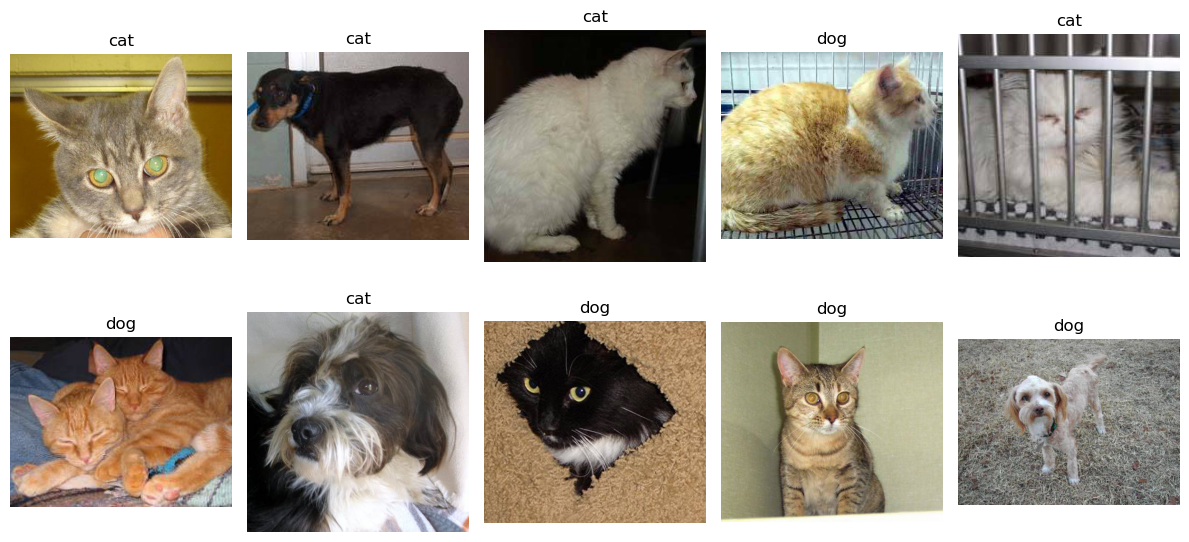

In [52]:
display_image_grid2(test_images_filepaths) 

In [21]:
import copy

#immutable
ori = [1,2,3]
cpy = ori
print(id(ori))
print(id(cpy))
cpy.append(100)
print(id(ori))
print(id(cpy))
print(cpy)
print(ori)

2758574427016
2758574427016
2758574427016
2758574427016
[1, 2, 3, 100]
[1, 2, 3, 100]


In [3]:
ori = [1,2,3]
cpy = ori
cpy[2] = 100
print(cpy)
print(ori)

[1, 2, 100]
[1, 2, 100]


In [6]:
#mutable은 얕은 복사의 개념이 필요없음 그냥 새롭게 개체 생성
ori = 1
cpy = ori
cpy = 100
print(cpy)
print(ori)

100
1


얕은 복사 / 메모리 참조를 복사

In [22]:
ori2 = [1,2,3]
cpy2 = copy.copy(ori2)
print(id(ori))
print(id(cpy))
cpy2.append(100)
print(id(ori))
print(id(cpy))
print(cpy2)
print(ori2)

2758574427016
2758574427016
2758574427016
2758574427016
[1, 2, 3, 100]
[1, 2, 3]


In [13]:
ori3 = [1,2,3]
cpy3 = copy.copy(ori3)
cpy3[2] = 100
print(cpy3)
print(ori3)

[1, 2, 100]
[1, 2, 3]


In [20]:
#append는 같은 메모리 이용
ori = [[1,2], 3]
cpy = copy.copy(ori)
print(id(ori))
print(id(cpy))
cpy[0].append(100)
print(id(ori))
print(id(cpy))
print(cpy)
print(ori)

2758574405576
2758535976136
2758574405576
2758535976136
[[1, 2, 100], 3]
[[1, 2, 100], 3]


In [17]:
#값을 넣어주는 것은 다른 메모리 생성
ori = [[1,2], 3]
cpy = copy.copy(ori)
cpy[0] = 100
print(cpy)
print(ori)

[100, 3]
[[1, 2], 3]


깊은 복사 / 아예 독립적인 개체 생성

In [10]:
ori = [1,2,3]
cpy = copy.deepcopy(ori)
cpy.append(100)
print(cpy)
print(ori)

[1, 2, 3, 100]
[1, 2, 3]


In [11]:
ori = [1,2,3]
cpy = copy.deepcopy(ori)
cpy[2] = 100
print(cpy)
print(ori)

[1, 2, 100]
[1, 2, 3]
